# 1. Libraries

In [1]:
!pip install sklearn
!pip install fancyimpute
!pip install missingpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.0 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=57bcf9a944ad5213c77edf6055fdbeba513b564c54d649dd77dde9344cf

In [2]:
import sklearn
print(sklearn.__version__)


1.2.2


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as MICE
from sklearn.metrics import confusion_matrix, classification_report


# 2. Preperation

In [36]:
df = pd.read_csv('df.csv')

# Select columns with numerical data
numerical_cols = df.select_dtypes(include=['float64']).columns

imputation_methods = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'mode': SimpleImputer(strategy='most_frequent'),
    'KNN': KNNImputer(n_neighbors=2),
    'MICE': MICE(),
    'Iterative': IterativeImputer(random_state=0),
}

df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [37]:
categorical = df.select_dtypes(exclude=np.number)
a = df.info(verbose=True)

print(a)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     340 non-null    float64
 1   bp      337 non-null    float64
 2   sg      302 non-null    float64
 3   al      303 non-null    float64
 4   su      300 non-null    float64
 5   rbc     200 non-null    object 
 6   pc      287 non-null    object 
 7   pcc     345 non-null    object 
 8   ba      345 non-null    object 
 9   bgr     306 non-null    float64
 10  bu      331 non-null    float64
 11  sc      332 non-null    float64
 12  sod     263 non-null    float64
 13  pot     262 non-null    float64
 14  hemo    298 non-null    float64
 15  pcv     279 non-null    float64
 16  wbcc    243 non-null    float64
 17  rbcc    218 non-null    float64
 18  htn     347 non-null    object 
 19  dm      347 non-null    object 
 20  cad     347 non-null    object 
 21  appet   348 non-null    object 
 22  pe

# 3. Model creation and training

In [38]:
all_train_losses = {}
all_val_losses = {}
all_train_accuracies = {}
all_val_accuracies = {}

# create a dictionary to store all the metrics
all_val_metrics = {
    'confusion_matrix': {},
    'classification_report': {}
}


for impute_name, imputer in imputation_methods.items():
    print(f"Imputing with {impute_name} method")
    df_imputed = df.copy()
    df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])

    # Fill missing values in categorical columns with the most frequent category
    for cat_col in df_imputed.select_dtypes(include=['object']).columns:
        df_imputed[cat_col].fillna(df_imputed[cat_col].mode()[0], inplace=True)

    # Preprocessing
    label_encoders = {}
    for cat_col in df_imputed.select_dtypes(include=['object']).columns:
        label_encoders[cat_col] = LabelEncoder()
        df_imputed[cat_col] = label_encoders[cat_col].fit_transform(df_imputed[cat_col])

    scaler = StandardScaler()
    df_imputed[df_imputed.select_dtypes(include=['float64']).columns] = scaler.fit_transform(df_imputed[df_imputed.select_dtypes(include=['float64']).columns])

    # Splitting the dataset
    train_df, temp_df = train_test_split(df_imputed, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    class CKDDataset(Dataset):
        def __init__(self, data):
            self.data = torch.tensor(data.drop(columns='class').values, dtype=torch.float32)
            self.targets = torch.tensor(data['class'].values, dtype=torch.long)

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.targets[idx]

    train_dataset = CKDDataset(train_df)
    train_loader = DataLoader(train_dataset, batch_size=16)

    val_dataset = CKDDataset(val_df)
    val_loader = DataLoader(val_dataset, batch_size=16)

    test_dataset = CKDDataset(test_df)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Define the network architecture
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(24, 24)
            self.fc2 = nn.Linear(24, 2)
            self.dropout = nn.Dropout(0.2) # 20% dropout rate

        def forward(self, x):
            x = nn.functional.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    # Initialize the network and define the loss function and optimizer
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(5):
        model.train()
        train_loss = 0.0
        correct = total = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total
        train_accuracies.append(train_acc)
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = total_val = 0
        val_preds = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_preds.extend(predicted.tolist())
                total_val += targets.size(0)
                correct_val += predicted.eq(targets).sum().item()

        # Calculate confusion matrix and classification report
        cm = confusion_matrix(val_df['class'], val_preds)
        cr = classification_report(val_df['class'], val_preds, output_dict=True)

        all_val_metrics['confusion_matrix'][impute_name] = cm
        all_val_metrics['classification_report'][impute_name] = cr

        val_acc = correct_val / total_val
        val_accuracies.append(val_acc)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')

all_train_losses[impute_name] = train_losses
all_val_losses[impute_name] = val_losses
all_train_accuracies[impute_name] = train_accuracies
all_val_accuracies[impute_name] = val_accuracies


Imputing with mean method
Epoch: 1, Train Loss: 0.626, Val Loss: 0.000, Train Acc: 0.684, Val Acc: 0.684
Epoch: 2, Train Loss: 0.518, Val Loss: 0.000, Train Acc: 0.836, Val Acc: 0.836
Epoch: 3, Train Loss: 0.442, Val Loss: 0.000, Train Acc: 0.873, Val Acc: 0.873
Epoch: 4, Train Loss: 0.377, Val Loss: 0.000, Train Acc: 0.926, Val Acc: 0.926
Epoch: 5, Train Loss: 0.313, Val Loss: 0.000, Train Acc: 0.971, Val Acc: 0.971
Imputing with median method
Epoch: 1, Train Loss: 0.719, Val Loss: 0.000, Train Acc: 0.426, Val Acc: 0.426
Epoch: 2, Train Loss: 0.610, Val Loss: 0.000, Train Acc: 0.742, Val Acc: 0.742
Epoch: 3, Train Loss: 0.516, Val Loss: 0.000, Train Acc: 0.910, Val Acc: 0.910
Epoch: 4, Train Loss: 0.431, Val Loss: 0.000, Train Acc: 0.943, Val Acc: 0.943
Epoch: 5, Train Loss: 0.369, Val Loss: 0.000, Train Acc: 0.943, Val Acc: 0.943
Imputing with mode method
Epoch: 1, Train Loss: 0.635, Val Loss: 0.000, Train Acc: 0.611, Val Acc: 0.611
Epoch: 2, Train Loss: 0.541, Val Loss: 0.000, Train

# 4. Visualizing the performance

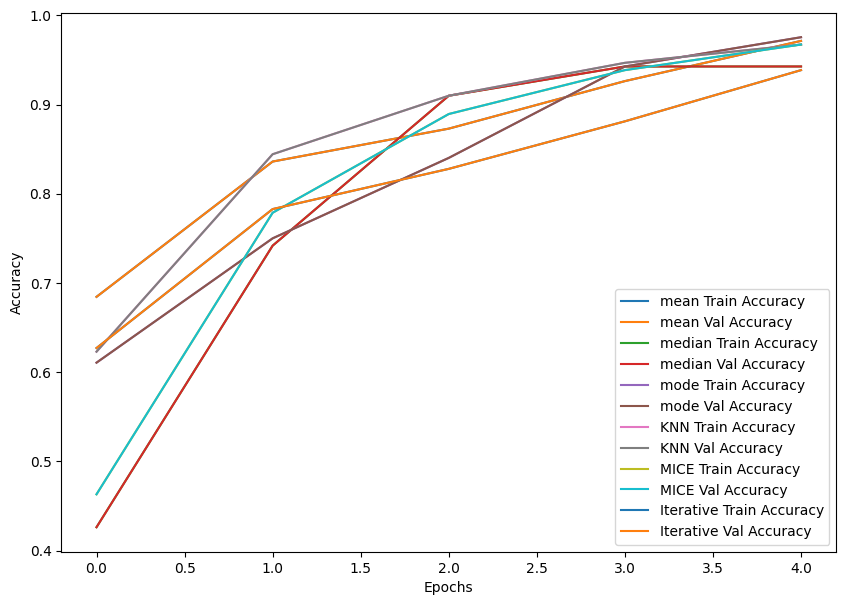

In [39]:
# Plotting train and validation accuracy
plt.figure(figsize=(10,7))
for impute_name in imputation_methods.keys():
    try:
        plt.plot(all_train_accuracies[impute_name], label=f'{impute_name} Train Accuracy')
        plt.plot(all_val_accuracies[impute_name], label=f'{impute_name} Val Accuracy')
    except KeyError:
        print(f"No data for {impute_name} in train/val accuracies")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

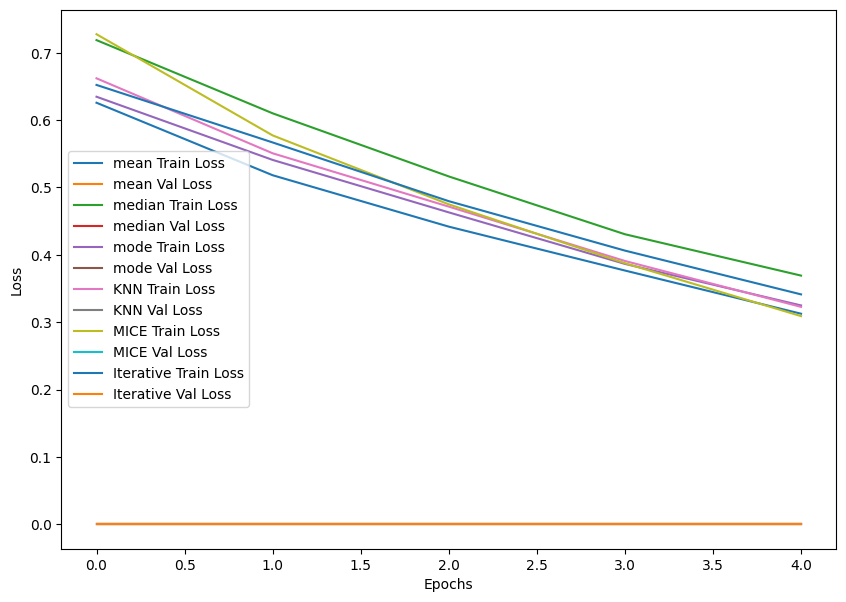

In [40]:
# Plotting train and validation loss
plt.figure(figsize=(10,7))
for impute_name in imputation_methods.keys():
    try:
        plt.plot(all_train_losses[impute_name], label=f'{impute_name} Train Loss')
        plt.plot(all_val_losses[impute_name], label=f'{impute_name} Val Loss')
    except KeyError:
        print(f"No data for {impute_name} in train/val losses")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5. evaluate on the test set

In [41]:
# Print metrics
for impute_name in imputation_methods.keys():
    try:
        print(f'For {impute_name} imputation:')
        print('Confusion Matrix:')
        print(all_val_metrics['confusion_matrix'][impute_name])
        print('Classification Report:')
        print(all_val_metrics['classification_report'][impute_name])
        print()
    except KeyError:
        print(f"No data for {impute_name} in validation metrics")

For mean imputation:
Confusion Matrix:
[[36  0]
 [ 0 16]]
Classification Report:
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 36}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52}}

For median imputation:
Confusion Matrix:
[[36  0]
 [ 0 16]]
Classification Report:
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 36}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52}}

For mode imputation:
Confusion Matrix:
[[35  1]
 [ 0 16]]
Classification Report:
{'0': {'precision': 1.0, 'recall': 0.9722222222222222, 'f1-score': 0.9859154929577464, 'support': 36}, 